In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import shutil
from sklearn.model_selection import train_test_split

2025-08-15 09:53:13.220592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755251593.243715      84 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755251593.250492      84 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
original_train_dir = "/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training"
base_output_dir = "/kaggle/working/split_dataset"


In [3]:
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15


for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_output_dir, split), exist_ok=True)

for class_name in os.listdir(original_train_dir):
    class_dir = os.path.join(original_train_dir, class_name)
    if not os.path.isdir(class_dir): continue

    images = os.listdir(class_dir)
    train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_class_dir = os.path.join(base_output_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img in split_imgs:
            src = os.path.join(class_dir, img)
            dst = os.path.join(split_class_dir, img)
            shutil.copy2(src, dst)

In [4]:
base_dir = "/kaggle/working/split_dataset"
img_size = (100, 100)
batch_size = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 72989 images belonging to 207 classes.


In [6]:
val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 15699 images belonging to 207 classes.


In [7]:
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 15768 images belonging to 207 classes.


In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(100,100,3))

/tmp/ipykernel_84/918999042.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(100,100,3))
I0000 00:00:1755252471.015442      84 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755252471.016213      84 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model_mobilenet = Model(inputs=base_model.input, outputs=output)

In [12]:
model_mobilenet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('mobilenet_best.h5', monitor='val_accuracy', save_best_only=True)
]

history_mobilenet = model_mobilenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1755252554.650108     156 service.cc:148] XLA service 0x7d9f7c010c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755252554.652149     156 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755252554.652170     156 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755252555.666923     156 cuda_dnn.cc:529] Loaded cuDNN version 90300


  10/2281 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.0015 - loss: 5.8304    

I0000 00:00:1755252560.244659     156 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2281/2281 ━━━━━━━━━━━━━━━━━━━━ 75s 27ms/step - accuracy: 0.5154 - loss: 2.5892 - val_accuracy: 0.9652 - val_loss: 0.2346
Epoch 2/30
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 51s 22ms/step - accuracy: 0.9753 - loss: 0.1739 - val_accuracy: 0.9913 - val_loss: 0.0786
Epoch 3/30
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 51s 22ms/step - accuracy: 0.9933 - loss: 0.0618 - val_accuracy: 0.9965 - val_loss: 0.0364
Epoch 4/30
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 50s 22ms/step - accuracy: 0.9969 - loss: 0.0295 - val_accuracy: 0.9971 - val_loss: 0.0220
Epoch 5/30
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 52s 23ms/step - accuracy: 0.9984 - loss: 0.0162 - val_accuracy: 0.9983 - val_loss: 0.0128
Epoch 6/30
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 53s 23ms/step - accuracy: 0.9989 - loss: 0.0093 - val_accuracy: 0.9985 - val_loss: 0.0088
Epoch 7/30
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 49s 22ms/step - accuracy: 0.9991 - loss: 0.0063 - val_accuracy: 0.9983 - val_loss: 0.0070
Epoch 8/30
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 50s 22ms/step - accuracy: 0.9995 - loss: 0.00

In [14]:
loss, acc = model_mobilenet.evaluate(test_generator)
print(f"Test Accuracy MobileNetV2: {acc*100:.2f}%")

493/493 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 1.0000 - loss: 3.3650e-04
Test Accuracy MobileNetV2: 100.00%


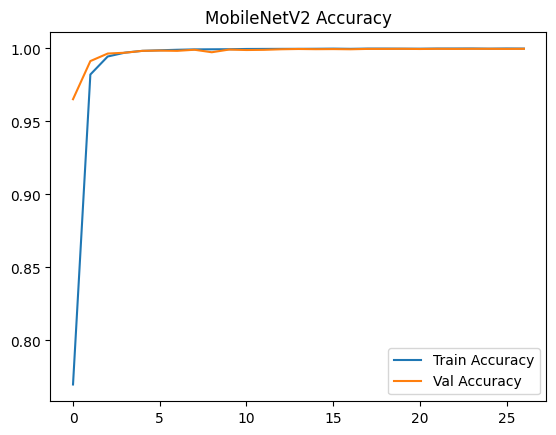

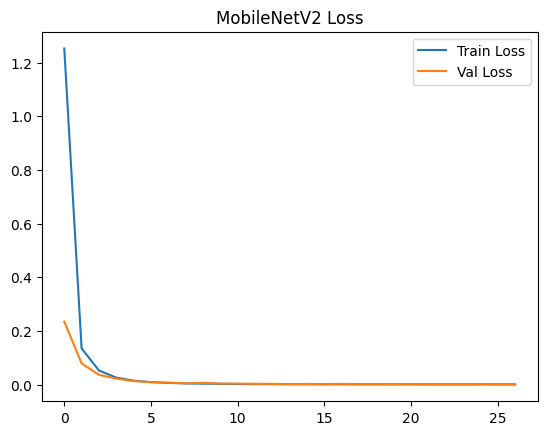

In [15]:
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Val Accuracy')
plt.title('MobileNetV2 Accuracy')
plt.legend()
plt.show()

plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Val Loss')
plt.title('MobileNetV2 Loss')
plt.legend()
plt.show()

In [16]:
save_path = '/kaggle/working/tf_best.h5'
model_mobilenet.save(save_path)